In [1]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict

eng = matlab.engine.start_matlab()

In [2]:
year = 2010
month = 1
day = 3
hour = 0
minute = 0
second = 0

startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day, hour+23, minute+59, second+59]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day, hour+23, minute+59, second+59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [3]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 371 ms, sys: 61.4 ms, total: 433 ms
Wall time: 3.09 s


In [4]:
%%time
from collections import OrderedDict

stationsYearMagPosition = OrderedDict(OrderedDict())
stationPosition = OrderedDict()  

for x in allMatData:  
    stationsYearMagPosition[str(x[1][0])] = OrderedDict()  
    try:
        for i in range(len(x[5][0])):
            stationPosition[x[5][0][i]] = x[9][0][i], x[10][0][i]
            stationsYearMagPosition[str(x[1][0])] = stationPosition.copy()
    except:
        print("no value")

CPU times: user 110 ms, sys: 3.03 ms, total: 113 ms
Wall time: 107 ms


In [52]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
    a1=np.float64(dataSt.get("a1")[timeshift])
#     x=np.float64(dataSt.get("x")[timeshift])
    x1=np.float64(dataSt.get("x1")[timeshift])
    x2=np.float64(dataSt.get("x2")[timeshift])
#     x3=np.float64(dataSt.get("x3")[timeshift])
#     x4=np.float64(dataSt.get("x4")[timeshift])
#     y=np.float64(dataSt.get("y")[timeshift])
    y1=np.float64(dataSt.get("y1")[timeshift])
#     y2=np.float64(dataSt.get("y2")[timeshift])
#     y3=np.float64(dataSt.get("y3")[timeshift])
#     y4=np.float64(dataSt.get("y4")[timeshift])
    z1=np.float64(dataSt.get("z1")[timeshift])
    stLongeo=np.float64(dataSt.get("longeo"))
    stLatgeo=np.float64(dataSt.get("latgeo"))
    stAlt=np.float64(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
    indicator = gaussian(ratio, 1, 0)
    return np.round(x1,10)

In [6]:
from IPython.display import clear_output

def drawMap(timeshift, date):
    clear_output(wait=True)
    plt.clf()
    w = 12
    h = 6
    d = 100
    x = range(360)
    y = range (180)
#     img = plt.imread("map2.png")
    plt.figure(figsize=(w, h), dpi=d)
#     plt.imshow(img, extent=[-180, 180, -90, 90])
    global dotsX
    del dotsX[:]
    global dotsY
    del dotsY[:]
    global dotsHeights
    del dotsHeights[:]
    
    
    for st in allStationCodes:
        if st != "ipm":
            try:
                stationIndicatorVariation[st].append(IndicatorCalculation(stationsOut.get(st), timeshift, date))
                dotsHeights.append(IndicatorCalculation(stationsOut.get(st), timeshift, date))
                if stationsOut.get(st).get("longeo")>180:
                    dotsX.append(stationsOut.get(st).get("longeo")-360)
                else:
                    dotsX.append(stationsOut.get(st).get("longeo"))
                dotsY.append(stationsOut.get(st).get("latgeo"))
            except:
                stationsWithNoData.append(st)
        else:
            None
                
    if not dotsX or not dotsY or not dotsHeights:
        print("No data given! Is the current date out of bounds? Current date: {} __ Max date: {}".format(date, endDate))
    else:
        contourMap()
        plt.colorbar()
        plt.suptitle(str(date), fontsize=14, fontweight='bold')
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()

In [7]:
from scipy.interpolate import griddata
import math


def contourMap():
    global dotsX
    global dotsY
    global dotsHeights
    
    for i in range(len(dotsHeights)):
        if math.isnan(dotsHeights[i]): dotsHeights[i]= 0

    xi = np.arange(-180,180,1)
    yi = np.arange(-90,90,1)
    xi,yi = np.meshgrid(xi,yi)

    zi = griddata((dotsX,dotsY),dotsHeights,(xi,yi),method='linear')
    
    plt.contourf(xi,yi,zi,np.arange(min(dotsHeights),max(dotsHeights)+0.1,0.1), cmap = "coolwarm")
    plt.plot(dotsX,dotsY,'k.')

In [8]:
def gaussian(x, alpha, r):
      return 1./(math.sqrt(alpha**math.pi))*np.exp(-alpha*np.power((x - r), 2.))

# x = np.linspace(-6, 6, 1000)
# fig= plt.figure(figsize=(20,8))
# axes= fig.add_axes([0.8,0.8,0.8,0.8])
# axes.plot(x, gaussian(x, 1, 0))
# plt.show()

In [53]:
stationIndicatorVariation.clear()
stationName = "clf"
timeBetweenValues =60

for st in allStationCodes:
    i=0 # En minutes
    delta = endDate-startDate
    totalMinutes = (delta.total_seconds()+1)/60
    while(i<=totalMinutes-1):
            try:
                update = datetime.timedelta(minutes=i)
                currentDate = startDate+update
                stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
            except:
                None
            i+=timeBetweenValues

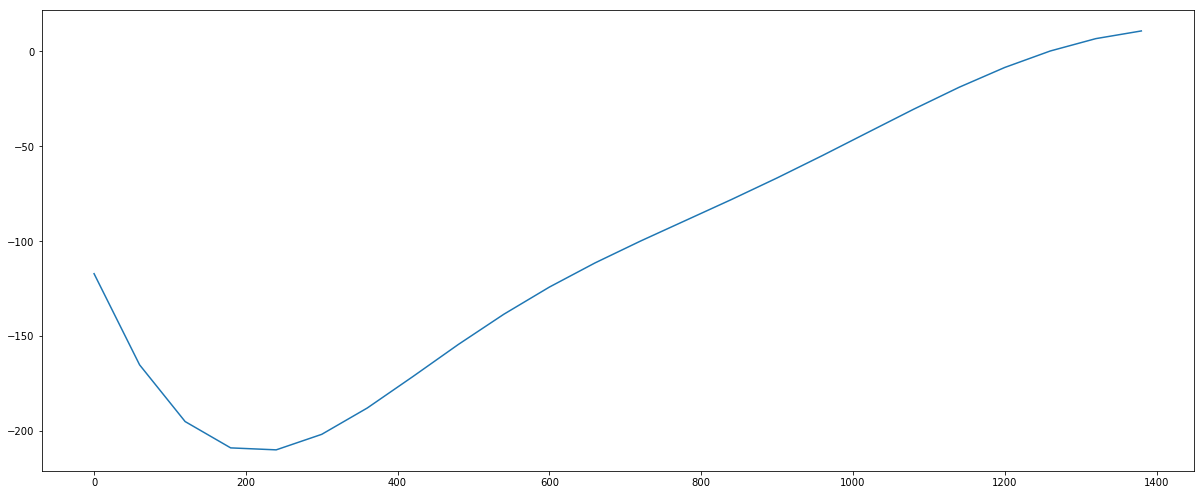

In [46]:


y = np.array(stationIndicatorVariation["ipm"])
x = np.arange(0, i, timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [11]:
from IPython.display import display
import ipywidgets as widgets

time=0
timeshift=60


upButton = widgets.Button(description="+{} minute(s)".format(timeshift))
downButton = widgets.Button(description="-{} minute(s)".format(timeshift))
output = widgets.Output()

def on_upButton_clicked(b):
    global timeshift
    global time
    global startDate
    time+=timeshift
    update = datetime.timedelta(minutes=time)
    currentDate = startDate+update
    with output:
        drawMap(time, currentDate);

upButton.on_click(on_upButton_clicked)


def on_downButton_clicked(b):
    global timeshift
    global time
    global startDate
    time-=timeshift
    update = datetime.timedelta(minutes=time)
    currentDate = startDate+update
    with output:
        drawMap(time, currentDate);

downButton.on_click(on_downButton_clicked)



buttons = widgets.HBox([downButton, upButton])
widgets.VBox([buttons, output])

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnLTYwIG1pbnV0ZShzKScsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCBCdXR0b24oZGVzY3JpcHRpb249dSfigKY=


In [54]:
indicatorVariationArray = np.full((180, 360), np.inf)

In [55]:
for st in allStationCodes:
    for i in range(-90, 90):
        try:
            if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
                indicatorVariationArray[i]=AdaptDimensions(np.array(stationIndicatorVariation[st]))
            else:
                None
        except:
            None

In [56]:
def AdaptDimensions(vector):
    outputVector=np.array([])
    shift=360/vector.shape[0]
    for y in range(0, vector.shape[0]):
        for i in range(0, shift):
            outputVector = np.append(outputVector, vector[y])
    return outputVector

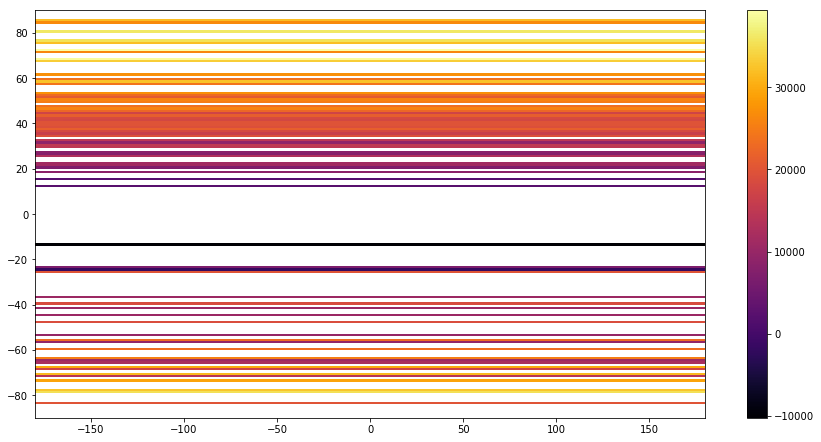

In [57]:
fig= plt.figure(figsize=(15,7.5))
plt.imshow(indicatorVariationArray, cmap=plt.get_cmap("inferno"), aspect='auto', extent=[-180,180,-90,90])
plt.colorbar()
plt.show()

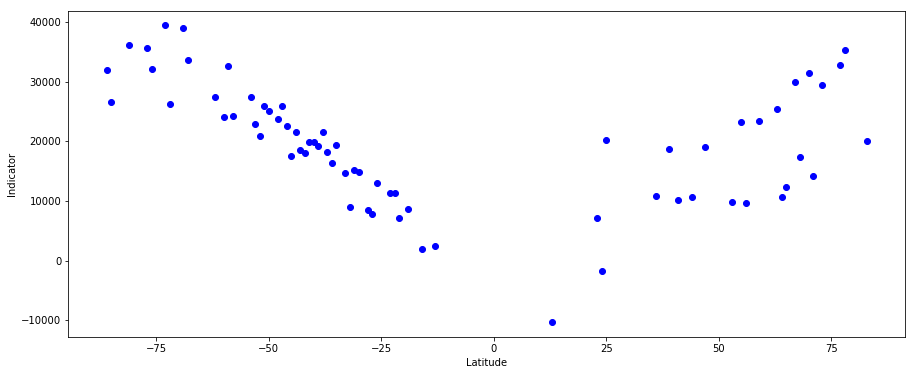

In [62]:
indicatorLatVariation = np.array([])
for i in range(0, 180):
    indicatorLatVariation = np.append(indicatorLatVariation, indicatorVariationArray[i][180])

y = np.array(indicatorLatVariation)
x = np.arange(-90, 90, 1)
plt.figure(figsize=(15,6))
plt.xlabel("Latitude")
plt.ylabel("Indicator")
plt.scatter(x, y, c = 'blue')
plt.show()



In [55]:
from IPython.display import clear_output

def drawMapForAnimation(timeshift, date):
    clear_output(wait=True)
    plt.clf()
    global dotsX
    del dotsX[:]
    global dotsY
    del dotsY[:]
    global dotsHeights
    del dotsHeights[:]
    global startDate
    
    for st in allStationCodes:
        if st != "ipm":
            try:
                update = datetime.timedelta(minutes=timeshift)
                currentDate = startDate+update
                dotsHeights.append(IndicatorCalculation(stationsOut.get(st), timeshift, currentDate))   
                if stationsOut.get(st).get("longeo")>180:
                    dotsX.append(stationsOut.get(st).get("longeo")-360)
                else:
                    dotsX.append(stationsOut.get(st).get("longeo"))
                dotsY.append(stationsOut.get(st).get("latgeo"))
            except:
                stationsWithNoData.append(st)
        else:
            None      
    if not dotsX or not dotsY or not dotsHeights:
        print("No data given! Is the current date out of bounds? Current date: {} __ Max date: {}".format(date, endDate))
    else:
        contourMap()
        plt.colorbar()
        update = datetime.timedelta(minutes=timeshift)
        currentDate = startDate+update
        plt.suptitle(str(currentDate), fontsize=14, fontweight='bold')

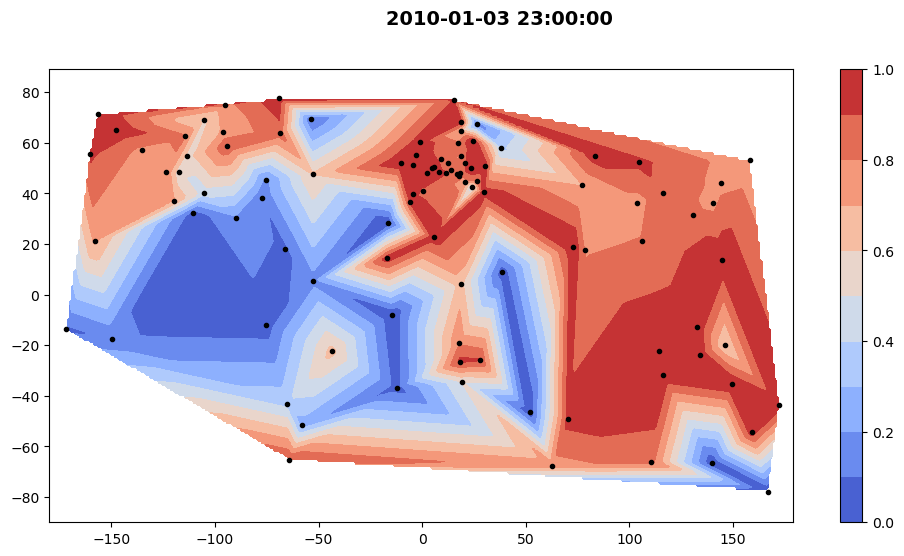

In [16]:
import matplotlib.animation as manimation

def MakeAnimation():
    FFMpegWriter = manimation.writers['html']
    writer = FFMpegWriter(fps=15)
    fig = plt.figure(figsize=(12, 6), dpi=100)
    
    plt.xlabel('longitude')
    plt.ylabel('latitude')

    plt.xlim(-180, 180)
    plt.ylim(-90, 90)

    i=0 # En minutes
    delta = endDate-startDate
    with writer.saving(fig, "MagneticVariationsAnimation.html", 100):
        while(i<=delta.total_seconds()/60):
            drawMapForAnimation(i, startDate)
            writer.grab_frame()
            i+=60
            
MakeAnimation()
